<a href="https://colab.research.google.com/github/Hamtak0/DeepLearning/blob/feature%2Fbinary_classification/binary_classification_rice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2023 Google LLC. Double-click for license information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Colabs

Machine Learning Crash Course uses Colaboratories (Colabs) for all programming exercises. Colab is Google's implementation of [Jupyter Notebook](https://jupyter.org/). For more information about Colabs and how to use them, go to [Welcome to Colaboratory](https://research.google.com/colaboratory).

# Binary classification

In this Colab, you'll complete the following tasks:
- Examine a dataset containing measurements derived from images of two species of Turkish rice.
- Create a binary classifier to sort grains of rice into the two species.
- Evaluate the performance of the model.

## Learning objectives

By completing this Colab, you'll learn:
- How to train a binary classifier.
- How to calculate metrics for a binary classifier at different thresholds.
- How to compare AUC and ROC of two different models.

## Dataset

This Colab uses the Cinar and Koklu 2019 Osmancik and Cammeo rice dataset.

Provided with a CC0 license (see [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik) for more documentation; lengths and area are given in pixels). Cinar and Koklu also provide datasets for multiclass (5 species of rice), pistachios, raisins, grape leaves, and so on, at their [repository](https://www.muratkoklu.com/datasets/).

### Citation

Cinar, I. and Koklu, M., (2019). “Classification of Rice Varieties Using Artificial Intelligence Methods.” *International Journal of Intelligent Systems and Applications in Engineering*, 7(3), 188-194.

DOI: https://doi.org/10.18201/ijisae.2019355381


# Load Imports

In [ ]:
# @title Install required libraries

!pip install google-ml-edu==0.1.2 \
    keras~=3.8.0 \
    matplotlib~=3.10.0 \
    numpy~=2.0.0 \
    pandas~=2.2.0 \
    tensorflow~=2.18.0

print('\n\nAll requirements successfully installed.')



All requirements successfully installed.


In [ ]:
# @title Load the imports

import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import ml_edu.experiment
import ml_edu.results
import numpy as np
import pandas as pd
import plotly.express as px

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


In [ ]:
# @title Load the dataset
rice_dataset_raw = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv")

Once the dataset has been loaded via the cell above, select specific columns to show summary statistics of the numerical features in the dataset.

See the Kaggle [dataset documentation](https://www.kaggle.com/datasets/muratkokludataset/rice-dataset-commeo-and-osmancik), especially the **Provenance** section, for explanations of what each feature means and how they were calculated.

In [ ]:
# @title
# Read and provide statistics on the dataset.
rice_dataset = rice_dataset_raw[[
    'Area',
    'Perimeter',
    'Major_Axis_Length',
    'Minor_Axis_Length',
    'Eccentricity',
    'Convex_Area',
    'Extent',
    'Class',
]]

rice_dataset.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0
mean,12667.7,454.2,188.8,86.3,0.9,12952.5,0.7
std,1732.4,35.6,17.4,5.7,0.0,1777.0,0.1
min,7551.0,359.1,145.3,59.5,0.8,7723.0,0.5
25%,11370.5,426.1,174.4,82.7,0.9,11626.2,0.6
50%,12421.5,448.9,185.8,86.4,0.9,12706.5,0.6
75%,13950.0,483.7,203.6,90.1,0.9,14284.0,0.7
max,18913.0,548.4,239.0,107.5,0.9,19099.0,0.9


## Task 1: Describe the data

From the summary statistics above, answer the following questions:
- What are the min and max lengths (major axis length, given in pixels) of the rice grains?
- What is the range of areas between the smallest and largest rice grains?
- How many standard deviations (`std`) is the largest rice grain's perimeter from the mean?

In [ ]:
# - What are the min and max lengths (major axis length, given in pixels) of the rice grains?

print("min : {:.1f}, max : {:.1f}".format(rice_dataset["Major_Axis_Length"].min(), rice_dataset["Major_Axis_Length"].max()))

# What is the range of areas between the smallest and largest rice grains?

print("range : {:.1f}".format(rice_dataset["Area"].max() - rice_dataset["Area"].min()))

# How many standard deviations (std) is the largest rice grain's perimeter from the mean?

print("std : {}".format((rice_dataset["Perimeter"].max() - rice_dataset["Perimeter"].mean()) / rice_dataset["Perimeter"].std()))

min : 145.3, max : 239.0
range : 11362.0
std : 2.6464754951724068


In [ ]:
# @title Solutions (run the cell to get the answers)

print(
    f'The shortest grain is {rice_dataset.Major_Axis_Length.min():.1f}px long,'
    f' while the longest is {rice_dataset.Major_Axis_Length.max():.1f}px.'
)
print(
    f'The smallest rice grain has an area of {rice_dataset.Area.min()}px, while'
    f' the largest has an area of {rice_dataset.Area.max()}px.'
)
print(
    'The largest rice grain, with a perimeter of'
    f' {rice_dataset.Perimeter.max():.1f}px, is'
    f' ~{(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f} standard'
    f' deviations ({rice_dataset.Perimeter.std():.1f}) from the mean'
    f' ({rice_dataset.Perimeter.mean():.1f}px).'
)
print(
    f'This is calculated as: ({rice_dataset.Perimeter.max():.1f} -'
    f' {rice_dataset.Perimeter.mean():.1f})/{rice_dataset.Perimeter.std():.1f} ='
    f' {(rice_dataset.Perimeter.max() - rice_dataset.Perimeter.mean())/rice_dataset.Perimeter.std():.1f}'
)

The shortest grain is 145.3px long, while the longest is 239.0px.
The smallest rice grain has an area of 7551px, while the largest has an area of 18913px.
The largest rice grain, with a perimeter of 548.4px, is ~2.6 standard deviations (35.6) from the mean (454.2px).
This is calculated as: (548.4 - 454.2)/35.6 = 2.6


# Explore the dataset

Plot some of the features against each other, including in 3D.


In [ ]:
# Create five 2D plots of the features against each other, color-coded by class.
for x_axis_data, y_axis_data in [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]:
  px.scatter(rice_dataset, x=x_axis_data, y=y_axis_data, color='Class').show()

## Task 2: Visualize samples in 3D

Try graphing three of the features in 3D against each other.

In [ ]:
#@title Plot three features in 3D by entering their names and running this cell

x_axis_data = 'Major_Axis_Length'  # @param {type: "string"}
y_axis_data = 'Area'  # @param {type: "string"}
z_axis_data = 'Perimeter'  # @param {type: "string"}

px.scatter_3d(
    rice_dataset,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='Class',
).show()

In [ ]:
# @title One possible solution

# Plot major and minor axis length and eccentricity, with observations
# color-coded by class.
px.scatter_3d(
    rice_dataset,
    x='Eccentricity',
    y='Area',
    z='Major_Axis_Length',
    color='Class',
).show()

If we were to pick three features, it seems that major axis length, area, and eccentricity might contain most of the information that differentiates the two classes. Other combinations may work as well.

Run the previous code cell to graph those three features if you haven't already.

It seems like a distinct class boundary appears in the plane of these three features. We'll train a model on just these features, then another model on the complete set of features, and compare their performance.

## Normalize data

When creating a model with multiple features, the values of each feature should span roughly the same range.  If one feature's values range from 500 to 100,000 and another feature's values range from 2 to 12, the model will need to have weights of extremely low or extremely high values to be able to combine these features effectively. This could result in a low quality model.  To avoid this,
[normalize](https://developers.google.com/machine-learning/glossary/#normalization) features in a multi-feature model.

This can be done by converting each raw value to its Z-score. The **Z-score** for a given value is how many standard deviations away from the mean the value is.

Consider a feature with a mean of 60 and a standard deviation of 10.

The raw value 75 would have a Z-score of +1.5:

```
  Z-score = (75 - 60) / 10 = +1.5
```

The raw value 38 would have a Z-score of -2.2:

```
  Z-score = (38 - 60) / 10 = -2.2
```

Now normalize the numerical values in the rice dataset by converting them to Z-scores.

In [ ]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = rice_dataset.mean(numeric_only=True)
feature_std = rice_dataset.std(numeric_only=True)
numerical_features = rice_dataset.select_dtypes('number').columns
normalized_dataset = (
    rice_dataset[numerical_features] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = rice_dataset['Class']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
normalized_dataset.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.5,2.0,2.3,-0.2,2.0,1.5,-1.2,Cammeo
1,1.1,1.1,1.0,0.9,0.4,1.2,-0.6,Cammeo
2,1.1,1.3,1.5,0.3,1.2,1.1,0.4,Cammeo
3,0.3,0.1,0.3,0.2,0.2,0.2,-0.3,Cammeo
4,1.2,1.5,1.3,0.5,1.0,1.3,-0.2,Cammeo


# Set the random seeds

To make experiments reproducible, we set the seed of the random number generators. This means that the order in which the data is shuffled, the values of the random weight initializations, etc, will all be the same each time the colab is run.

In [ ]:
keras.utils.set_random_seed(42)

## Label and split data

To train the model, we'll arbritrarily assign the Cammeo species a label of '1' and the Osmancik species a label of '0'.

In [ ]:
# Create a column setting the Cammeo label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Cammeo, and false if class is Osmancik
    normalized_dataset['Class'] == 'Cammeo'
).astype(int)
normalized_dataset.sample(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
1011,-0.1,0.1,-0.1,0.2,-0.1,-0.0,-1.0,Cammeo,1
3185,-0.1,-0.5,-0.5,0.4,-0.8,-0.2,-0.3,Osmancik,0
3698,0.1,-0.1,-0.4,0.9,-1.1,0.1,-0.2,Osmancik,0
897,0.2,0.5,0.8,-0.5,1.2,0.2,1.5,Cammeo,1
3245,-1.3,-1.3,-0.9,-1.6,0.5,-1.4,-1.1,Osmancik,0
478,0.2,0.2,0.4,-0.0,0.5,0.2,1.7,Cammeo,1
1731,-0.4,-0.8,-0.8,0.3,-1.0,-0.5,-0.4,Osmancik,0
1025,0.6,0.7,0.6,0.3,0.5,0.6,-0.5,Cammeo,1
429,1.2,1.2,1.4,0.6,1.0,1.2,1.8,Cammeo,1
1330,-0.4,-0.0,0.4,-1.3,1.4,-0.5,-0.1,Cammeo,1


We can then randomize and partition the dataset into train, test, and validation splits, consisting of 80%, 10%, and 10% of the dataset respectively.

In [ ]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
test_data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
2405,-0.4,-0.7,-0.8,0.3,-1.1,-0.4,0.3,Osmancik,0
3062,-0.2,-0.0,0.2,-0.7,0.8,-0.2,1.6,Osmancik,0
1155,1.4,1.2,1.1,1.2,0.3,1.3,0.7,Cammeo,1
660,1.2,1.0,0.8,1.3,-0.0,1.2,-0.6,Cammeo,1
2451,-1.2,-1.2,-1.4,-0.3,-1.5,-1.1,0.1,Osmancik,0


It's important to prevent the model from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [ ]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

## Train the model

### Choose the input features

To start with, we'll train a model on `Eccentricity`, `Major_Axis_Length,` and `Area`.

In [ ]:
# Name of the features we'll train our model on.
input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(inputs, learning_rate, metrics)`, which defines the model's architecture.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Note: create_model applies the sigmoid function to perform [logistic regression](https://developers.google.com/machine-learning/crash-course/logistic-regression).

We also define two helpful data structures: `ExperimentSettings` and `Experiment`. We use these simple classes to keep track of our experiments, allowing us to know what hyperparameters were used and what the results were. In `ExperimentSettings`, we store all values describing an experiment (i.e., hyperparameters). Then, we store the results of a training run (i.e., the model and the training metrics) into an `Experiment` instance, along with the `ExperimentSettings` used for that experiment.

In [27]:
# @title Define the functions that create and train a model.


def create_model(
    settings: ml_edu.experiment.ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  model_output = keras.layers.Dense(
      units=1, name='dense_layer', activation=keras.activations.sigmoid
  )(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ml_edu.experiment.ExperimentSettings,
) -> ml_edu.experiment.Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return ml_edu.experiment.Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


## Define a plotting function

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

## Invoke the creating, training, and plotting functions

The following code specifies the hyperparameters, invokes the
functions to create and train the model, then plots the results, including accuracy, precision, and recall.

Classification threshold is set at .35. Try playing with the threshold, then the learning rate, to see what changes.

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7411 - auc: 0.9295 - loss: 0.4423 - precision: 0.6315 - recall: 0.9887
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7569 - auc: 0.9368 - loss: 0.4229 - precision: 0.6470 - recall: 0.9853
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7695 - auc: 0.9417 - loss: 0.4068 - precision: 0.6602 - recall: 0.9815
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7857 - auc: 0.9459 - loss: 0.3919 - precision: 0.6782 - recall: 0.9767
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8044 - auc: 0.9491 - loss: 0.3780 - precision: 0.6990 - recall: 0.9760
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8109 - auc: 0.9520 - loss: 0.3651 - precision: 0.7071 - recall: 0.9738
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8192 - auc: 0.9545 - loss: 0.3530 - precision: 0.7177 - recall: 0.9713
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

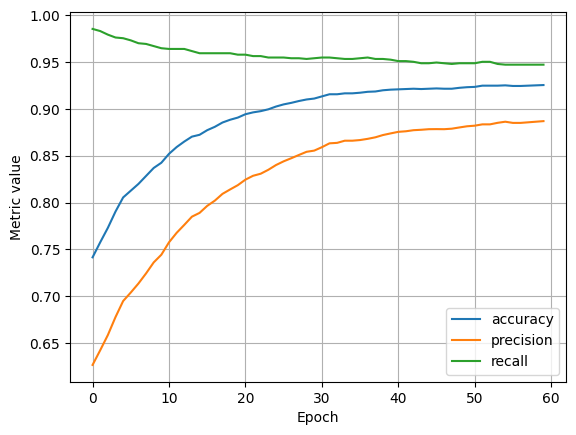

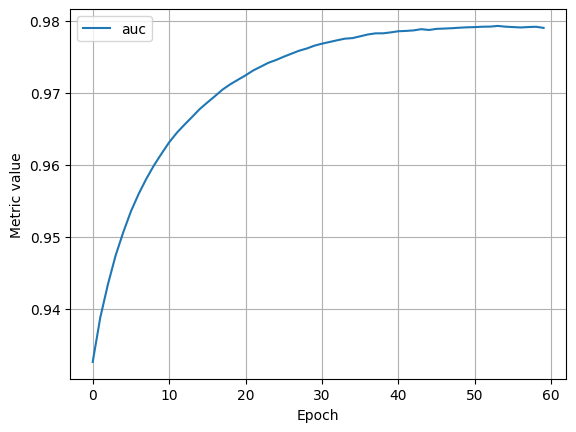

In [31]:
# Let's define our first experiment settings.
settings1 = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics1 = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings1.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings1.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings1.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model1 = create_model(settings1, metrics1)

# Train the model on the training set.
experiment1 = train_model(
    'baseline', model1, train_features, train_labels, settings1
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(experiment1, ['accuracy', 'precision', 'recall'])
ml_edu.results.plot_experiment_metrics(experiment1, ['auc'])

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8747 - auc: 0.9595 - loss: 0.3566 - precision: 0.9402 - recall: 0.7633
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8767 - auc: 0.9612 - loss: 0.3433 - precision: 0.9371 - recall: 0.7709
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8791 - auc: 0.9626 - loss: 0.3324 - precision: 0.9380 - recall: 0.7759
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8813 - auc: 0.9639 - loss: 0.3222 - precision: 0.9403 - recall: 0.7791
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8832 - auc: 0.9651 - loss: 0.3128 - precision: 0.9414 - recall: 0.7826
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8862 - auc: 0.9661 - loss: 0.3040 - precision: 0.9473 - recall: 0.7844
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - auc: 0.9673 - loss: 0.2958 - precision: 0.9477 - recall: 0.7909
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

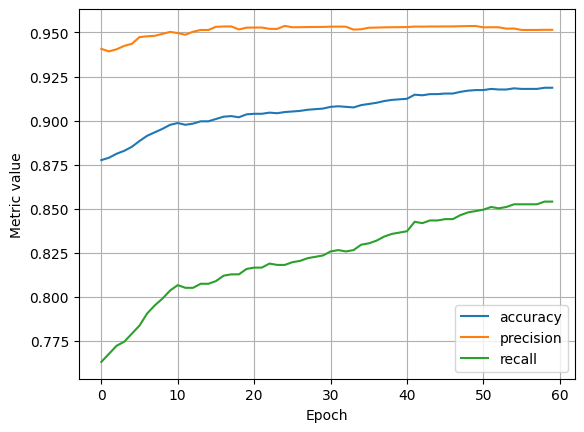

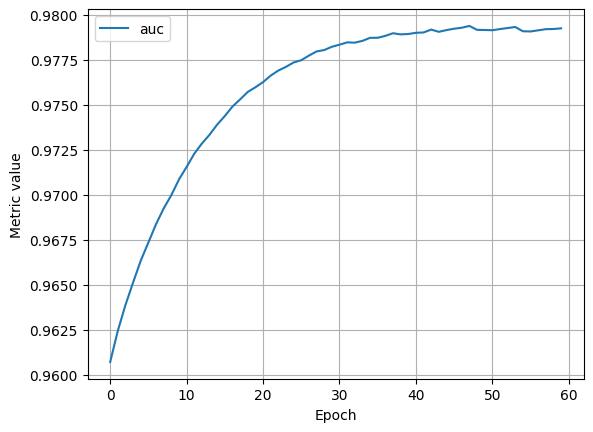

In [29]:
# Modifying the classification threshold
settings2 = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.70,
    input_features=input_features,
)

metrics2 = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings2.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings2.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings2.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model2 = create_model(settings2, metrics2)

# Train the model on the training set.
experiment2 = train_model(
    'baseline', model2, train_features, train_labels, settings2
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(experiment2, ['accuracy', 'precision', 'recall'])
ml_edu.results.plot_experiment_metrics(experiment2, ['auc'])

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8094 - auc: 0.9480 - loss: 0.3969 - precision: 0.9448 - recall: 0.6032
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8703 - auc: 0.9676 - loss: 0.2895 - precision: 0.9559 - recall: 0.7396
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - auc: 0.9730 - loss: 0.2421 - precision: 0.9578 - recall: 0.7977
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - auc: 0.9758 - loss: 0.2153 - precision: 0.9488 - recall: 0.8219
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9042 - auc: 0.9772 - loss: 0.2003 - precision: 0.9471 - recall: 0.8286
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9060 - auc: 0.9776 - loss: 0.1928 - precision: 0.9448 - recall: 0.8353
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9114 - auc: 0.9775 - loss: 0.1896 - precision: 0.9453 - recall: 0.8478
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

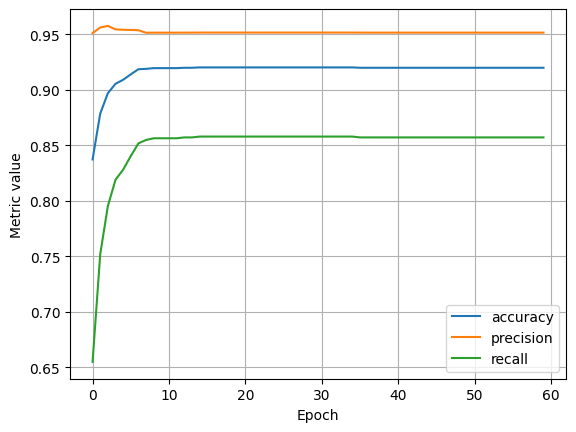

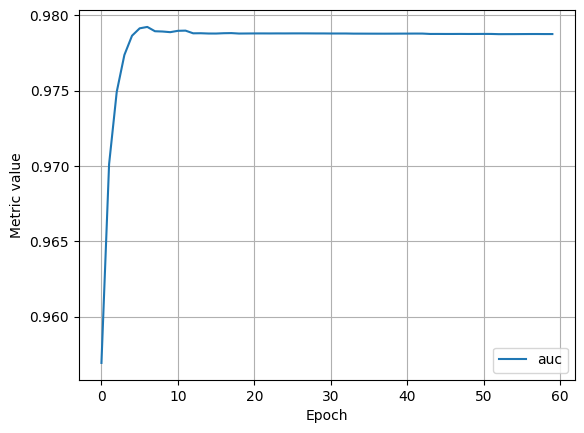

In [32]:
# Playing with learning rate
settings3 = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.01,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.70,
    input_features=input_features,
)

metrics3 = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings3.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings3.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings3.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model3 = create_model(settings3, metrics3)

# Train the model on the training set.
experiment3 = train_model(
    'baseline', model3, train_features, train_labels, settings3
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(experiment3, ['accuracy', 'precision', 'recall'])
ml_edu.results.plot_experiment_metrics(experiment3, ['auc'])

AUC is calculated across all possible thresholds (in practice in the code above, 100 thresholds), while accuracy, precision, and recall are calculated for only the specified threshold. For this reason they are shown separately above.

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [40]:
def compare_train_test(experiment: ml_edu.experiment.Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = experiment1.evaluate(test_features, test_labels)
compare_train_test(experiment1, test_metrics)
print()
test_metrics2 = experiment2.evaluate(test_features, test_labels)
compare_train_test(experiment2, test_metrics2)
print()
test_metrics3 = experiment3.evaluate(test_features, test_labels)
compare_train_test(experiment3, test_metrics3)

Comparing metrics between train and test:
------
Train accuracy: 0.9255
Test accuracy:  0.9081
------
Train auc: 0.9790
Test auc:  0.9756
------
Train loss: 0.1826
Test loss:  0.1938
------
Train precision: 0.8870
Test precision:  0.8545
------
Train recall: 0.9473
Test recall:  0.9276

Comparing metrics between train and test:
------
Train accuracy: 0.9186
Test accuracy:  0.9081
------
Train auc: 0.9792
Test auc:  0.9761
------
Train loss: 0.1816
Test loss:  0.1929
------
Train precision: 0.9515
Test precision:  0.9606
------
Train recall: 0.8541
Test recall:  0.8026

Comparing metrics between train and test:
------
Train accuracy: 0.9199
Test accuracy:  0.9055
------
Train auc: 0.9788
Test auc:  0.9759
------
Train loss: 0.1808
Test loss:  0.1918
------
Train precision: 0.9517
Test precision:  0.9531
------
Train recall: 0.8571
Test recall:  0.8026


It appears that the model, which achieved ~92% accuracy on the training data, still shows an accuracy of about 90% on the test data. Can we do better? Let's train a model using all seven available features and compare the AUC.

In [36]:
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Perimeter',
  'Convex_Area',
  'Extent',
]

In [35]:
#@title Solution
# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Convex_Area',
  'Perimeter',
  'Extent',
]

## Train the full-featured model and calculate metrics

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6713 - auc: 0.7788 - loss: 0.5701 - precision: 0.6226 - recall: 0.6482
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7534 - auc: 0.8387 - loss: 0.5147 - precision: 0.7050 - recall: 0.7581
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7984 - auc: 0.8792 - loss: 0.4711 - precision: 0.7494 - recall: 0.8158
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8302 - auc: 0.9088 - loss: 0.4326 - precision: 0.7832 - recall: 0.8506
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - auc: 0.9291 - loss: 0.3987 - precision: 0.8050 - recall: 0.8740
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8710 - auc: 0.9432 - loss: 0.3689 - precision: 0.8290 - recall: 0.8918
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8823 - auc: 0.9532 - loss: 0.3430 - precision: 0.8480 - recall: 0.8936
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

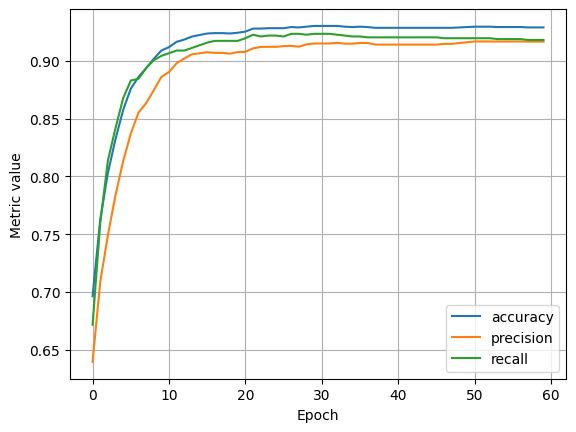

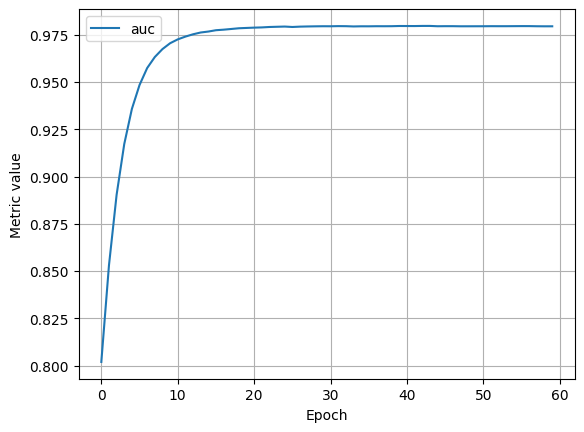

In [37]:
settings_all_features = ml_edu.experiment.ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_input_features,
)

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
ml_edu.results.plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
ml_edu.results.plot_experiment_metrics(experiment_all_features, ['auc'])

## Evaluate full-featured model on test split

In [38]:
test_metrics_all_features = experiment_all_features.evaluate(
    test_features,
    test_labels,
)
compare_train_test(experiment_all_features, test_metrics_all_features)

Comparing metrics between train and test:
------
Train accuracy: 0.9291
Test accuracy:  0.9265
------
Train auc: 0.9794
Test auc:  0.9762
------
Train loss: 0.1792
Test loss:  0.1899
------
Train precision: 0.9169
Test precision:  0.9133
------
Train recall: 0.9183
Test recall:  0.9013


This second model has very similar train and test metrics, suggesting it overfit less to the training data.

# Comparing our two models

With our simple experimentation framework, we can keep track of which experiments we ran, and what the results were. We can also define a helper function below which allows us to easily compare two or more models, both during training and when evaluated on the test set.

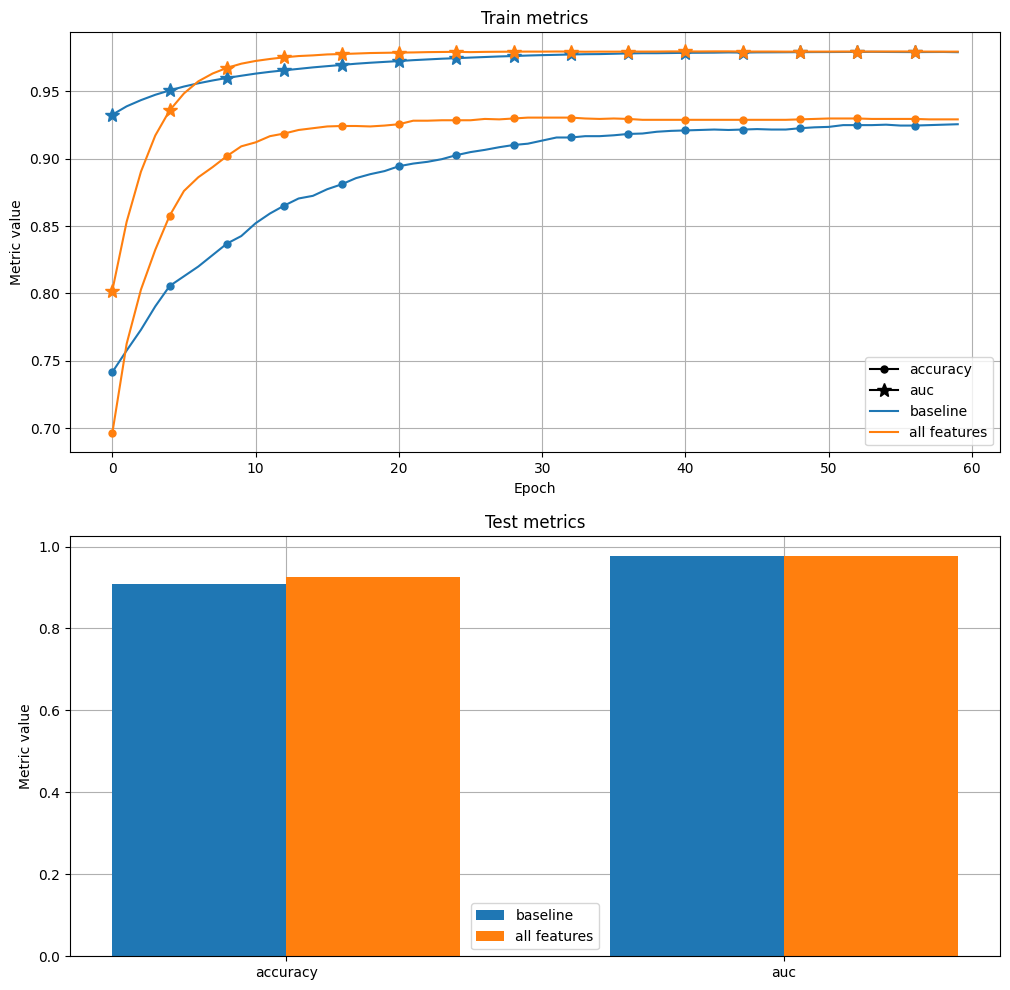

In [39]:
ml_edu.results.compare_experiment([experiment1, experiment_all_features],
                                  ['accuracy', 'auc'],
                                  test_features, test_labels)

Comparing the two models, both have AUC of ~.97-.98. There does not seem to be a large gain in model quality when adding the other four features, which makes sense, given that many of the features (area, perimeter, and convex area, for example) are interrelated.